In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils 


from torchvision import transforms

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## custom Batch Generator

### 1. load trn, val data

In [2]:
trn = pd.read_csv("./dnn_data/trn.tsv", sep='\t')
val = pd.read_csv("./dnn_data/val.tsv", sep='\t')

In [3]:
trn.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,y
0,0.770747,1.777481,1.119744,10,0.904246,0.750227,6,7,74.559605
1,0.517279,2.102868,1.433156,10,0.835582,0.982529,4,1,68.654484
2,0.528888,2.287112,1.181075,1,0.944968,0.961392,7,2,81.007162
3,0.398252,1.285644,0.968844,1,0.946535,0.748881,7,7,82.157630
4,0.483614,2.503184,1.563709,10,0.936454,0.945359,7,10,86.360000


In [4]:
X_features = ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6", "feature_7", "feature_8"]
y_feature = ["y"]

In [5]:
trn_X_pd, trn_y_pd = trn[X_features], trn[y_feature]
val_X_pd, val_y_pd = val[X_features], val[y_feature]

In [19]:
trn_X = torch.from_numpy(trn_X_pd.astype(float).values)
trn_y = torch.from_numpy(trn_y_pd.astype(float).values)

val_X = torch.from_numpy(val_X_pd.astype(float).values)
val_y = torch.from_numpy(val_y_pd.astype(float).values)

In [7]:
batch_size=64

In [20]:
trn = data_utils.TensorDataset(trn_X, trn_y)
trn_loader = data_utils.DataLoader(trn, batch_size=batch_size, shuffle=True)

val = data_utils.TensorDataset(val_X, val_y)
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

In [21]:
tmp = next(iter(trn_loader))

In [22]:
tmp

[tensor([[5.8083e-01, 2.3504e+00, 7.2618e-01, 1.0000e+00, 1.0000e+00, 9.8835e-01,
          5.0000e+00, 8.0000e+00],
         [6.8490e-01, 2.6601e+00, 7.0480e-01, 1.0000e+00, 7.8875e-01, 9.5704e-01,
          7.0000e+00, 9.0000e+00],
         [5.9617e-01, 2.1074e+00, 6.8805e-01, 1.0000e+01, 6.5303e-01, 9.5500e-01,
          4.0000e+00, 2.0000e+00],
         [4.6618e-01, 2.4170e+00, 9.9786e-01, 1.0000e+00, 6.2376e-01, 9.7757e-01,
          6.0000e+00, 2.0000e+00],
         [5.0665e-01, 1.7576e+00, 9.9688e-01, 1.0000e+00, 1.0000e+00, 8.4077e-01,
          7.0000e+00, 9.0000e+00],
         [4.9069e-01, 2.5487e+00, 2.1666e+00, 1.0000e+00, 9.9189e-01, 9.9980e-01,
          6.0000e+00, 1.0000e+01],
         [7.1390e-01, 2.5845e+00, 1.1495e+00, 1.0000e+00, 8.5633e-01, 9.9519e-01,
          6.0000e+00, 8.0000e+00],
         [6.7145e-01, 2.5900e+00, 1.6690e+00, 1.0000e+00, 1.0000e+00, 9.6371e-01,
          6.0000e+00, 1.0000e+00],
         [4.7936e-01, 2.1349e+00, 1.8340e-01, 1.0000e+01, 6.0059

In [23]:
# for dictionary batch
class Dataset(data_utils.Dataset):
   
    def __init__(self, X, y):
        self.X = X
        self.y = y
   
    def __getitem__(self, idx):
        return {'X': self.X[idx], 'y': self.y[idx]}
   
    def __len__(self):
        return len(self.X)

In [24]:
trn = Dataset(trn_X, trn_y)
trn_loader = data_utils.DataLoader(trn, batch_size=batch_size, shuffle=True)

val = Dataset(val_X, val_y)
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

In [25]:
tmp = next(iter(trn_loader))

In [26]:
tmp

{'X': tensor([[6.8642e-01, 3.0662e+00, 1.0430e+00, 1.0000e+00, 7.3301e-01, 9.8043e-01,
          7.0000e+00, 5.0000e+00],
         [6.4069e-01, 3.3031e+00, 8.0163e-02, 9.0000e+00, 7.1114e-01, 9.6430e-01,
          9.0000e+00, 1.2000e+01],
         [6.1958e-01, 2.6973e+00, 1.0070e+00, 1.0000e+01, 5.4546e-01, 9.9144e-01,
          7.0000e+00, 3.0000e+00],
         [5.0175e-01, 1.5722e+00, 1.2750e+00, 1.0000e+00, 6.7294e-01, 6.9731e-01,
          7.0000e+00, 1.3000e+01],
         [5.6134e-01, 1.6326e+00, 3.3743e+00, 1.0000e+01, 9.8828e-01, 7.1937e-01,
          6.0000e+00, 1.1000e+01],
         [3.9965e-01, 1.5086e+00, 5.6467e-01, 1.0000e+01, 6.1882e-01, 7.5318e-01,
          7.0000e+00, 1.0000e+00],
         [4.9889e-01, 2.1329e+00, 4.6555e-01, 1.0000e+01, 7.2297e-01, 7.6876e-01,
          7.0000e+00, 1.2000e+01],
         [4.9348e-01, 2.5340e+00, 7.9817e-01, 7.0000e+00, 9.9741e-01, 9.5803e-01,
          7.0000e+00, 3.0000e+00],
         [5.6068e-01, 2.7336e+00, 1.1058e+00, 1.0000e+00, 6

In [32]:
num_batches = len(trn_loader)

## Build Model

In [33]:
use_cuda = torch.cuda.is_available()

In [34]:
class MLPRegressor(nn.Module):
    
    def __init__(self):
        super(MLPRegressor, self).__init__()
        h1 = nn.Linear(len(X_features), 50)
        h2 = nn.Linear(50, 35)
        h3 = nn.Linear(35, 1)
        self.hidden = nn.Sequential(
            h1,
            nn.Tanh(),
            h2,
            nn.Tanh(),
            h3,
        )
        if use_cuda:
            self.hidden = self.hidden.cuda()
        
    def forward(self, x):
        o = self.hidden(x)
        return o.view(-1)

## Train model

In [35]:
model = MLPRegressor()

In [36]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
num_epochs = 10
num_batches = len(trn_loader)

In [38]:
num_batches

35

In [39]:
trn_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    trn_loss_summary = 0.0
    for i, trn in enumerate(trn_loader):
        trn_X, trn_y = trn['X'], trn['y']
        if use_cuda:
            trn_X, trn_y = trn_X.cuda(), trn_y.cuda()
        optimizer.zero_grad()
        trn_pred = model(trn_X)
        trn_loss = criterion(trn_pred, trn_y)
        trn_loss.backward()
        optimizer.step()
        
        trn_loss_summary += trn_loss
        
        if (i+1) % 15 == 0:
            with torch.no_grad():
                val_loss_summary = 0.0
                for j, val in enumerate(val_loader):
                    val_X, val_y = val['X'], val['y']
                    if use_cuda:
                        val_X, val_y = val_X.cuda(), val_y.cuda()
                    val_pred = model(val_X)
                    val_loss = criterion(val_pred, val_y)
                    val_loss_summary += val_loss
                
            print("epoch: {}/{} | step: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch + 1, num_epochs, i+1, num_batches, (trn_loss_summary/15)**(1/2), (val_loss_summary/len(val_loader))**(1/2)
            ))
                
            trn_loss_list.append((trn_loss_summary/15)**(1/2))
            val_loss_list.append((val_loss_summary/len(val_loader))**(1/2))
            trn_loss_summary = 0.0
        
print("finish Training")

epoch: 1/10 | step: 15/35 | trn_loss: 80.4772 | val_loss: 79.9006
epoch: 1/10 | step: 30/35 | trn_loss: 79.5698 | val_loss: 78.7983
epoch: 2/10 | step: 15/35 | trn_loss: 77.8362 | val_loss: 76.9738
epoch: 2/10 | step: 30/35 | trn_loss: 76.5909 | val_loss: 75.7759
epoch: 3/10 | step: 15/35 | trn_loss: 75.1105 | val_loss: 74.2213
epoch: 3/10 | step: 30/35 | trn_loss: 73.8596 | val_loss: 73.4308
epoch: 4/10 | step: 15/35 | trn_loss: 72.9306 | val_loss: 72.4381
epoch: 4/10 | step: 30/35 | trn_loss: 72.2745 | val_loss: 71.6900
epoch: 5/10 | step: 15/35 | trn_loss: 71.4342 | val_loss: 70.8200
epoch: 5/10 | step: 30/35 | trn_loss: 70.6700 | val_loss: 70.2096
epoch: 6/10 | step: 15/35 | trn_loss: 69.7620 | val_loss: 69.4448
epoch: 6/10 | step: 30/35 | trn_loss: 69.3763 | val_loss: 68.8077
epoch: 7/10 | step: 15/35 | trn_loss: 68.6557 | val_loss: 68.0679
epoch: 7/10 | step: 30/35 | trn_loss: 67.7106 | val_loss: 67.4442
epoch: 8/10 | step: 15/35 | trn_loss: 66.9765 | val_loss: 66.6800
epoch: 8/1

### Visualize

Text(0,0.5,'loss')

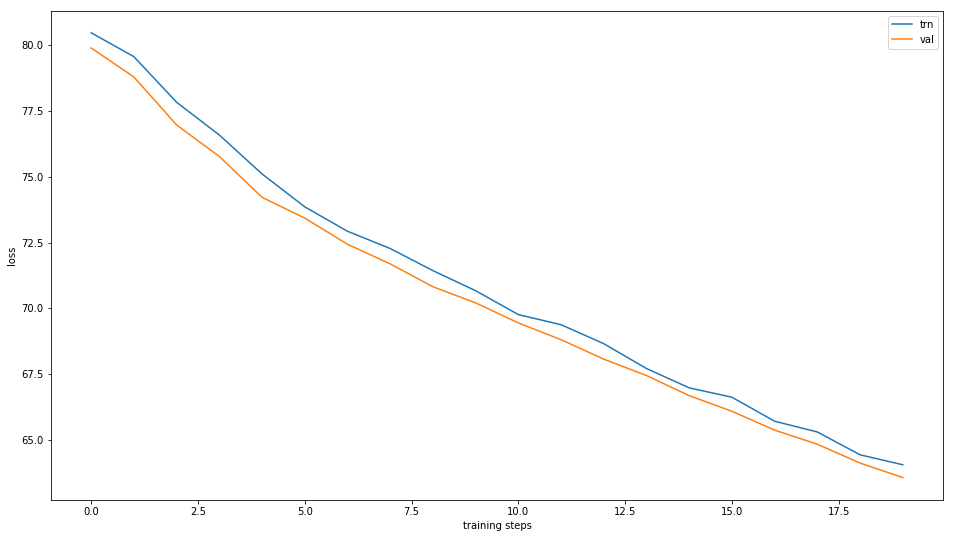

In [40]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")